# Курс Python для DataScience
# Курсовой проект №2
## Тема “Credit Default”
Geekbrains Python for Data Science course competition

Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).


Invite link for this competition: https://www.kaggle.com/t/629f0f9238324b9d819d26838be92544


Метрика: The evaluation metric for this competition is F1-Score.

### Подключение библиотек и скриптов

In [1]:
import pandas as pd
import numpy as np

In [2]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
#%%script false
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, precision_recall_curve)
import matplotlib

In [4]:
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns

from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 14}) 
%matplotlib inline

from datetime import datetime

C:\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
C:\Anaconda3\lib\site

In [5]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [6]:
def eda(prop, bins_ = 5, tg_ = 0):
    """ вывод свойств
    """
    print(f'train_df[{prop}].head() \n{train_df[prop].head()}\n')
    print(f'train_df[{prop}].describe() \n{train_df[prop].describe()}\n')
    print(f'train_df[{prop}].value_counts() \n{train_df[prop].value_counts()}\n')
    print(f'train_df[{prop}].sort_values().unique() \n{train_df[prop].sort_values().unique()}\n')
    df_num = train_df[prop]
    df_num.hist(figsize=(4,4), bins=bins_, grid=True)
    
    if tg_ == 1 :
        plt.figure(figsize=(4, 4))
        sns.countplot(x=prop, hue='Credit Default', data=train_df)
        plt.title(prop + ' grouped by target variable')
        plt.legend(title='Target', loc='upper right')
        plt.show()

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    report = {'train_report': classification_report(y_train_true, y_train_pred), 
              'test_report':classification_report(y_test_true, y_test_pred),
              'crosstab': pd.crosstab(y_test_true, y_test_pred)}
    return report 

In [8]:
t1 = datetime.now()
np.random.seed(42)

In [9]:
#TRAIN_DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'
#TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'
TRAIN_DATASET_PATH = './input/train.csv'  
TEST_DATASET_PATH = './input/test.csv'

### Описание датасета

#### File descriptions

* train.csv - the training set
* test.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

#### Data fields

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head().transpose()

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087,1.02549e+06,751412,805068,776264
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0,0,0,0,0
Number of Open Accounts,11,15,11,8,13
Years of Credit History,26.3,15.3,35,22.5,13.6
Maximum Open Credit,685960,1.18173e+06,1.18243e+06,147400,385836
Number of Credit Problems,1,0,0,1,1
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1,0,0,1,0


In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [12]:
print(f'train_df: строк - {train_df.shape[0]}, признаков - {train_df.shape[1]}')
print(f'test_df: строк - {test_df.shape[0]}, признаков - {test_df.shape[1]}')

train_df: строк - 7500, признаков - 17
test_df: строк - 2500, признаков - 16


## EDA

### Целевая переменная

train_df[Credit Default].head() 
0    0
1    1
2    0
3    0
4    0
Name: Credit Default, dtype: int64

train_df[Credit Default].describe() 
count    7500.000000
mean        0.281733
std         0.449874
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Credit Default, dtype: float64

train_df[Credit Default].value_counts() 
0    5387
1    2113
Name: Credit Default, dtype: int64

train_df[Credit Default].sort_values().unique() 
[0 1]



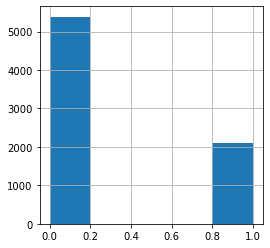

In [13]:
eda('Credit Default')

### Количественные переменные

In [14]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


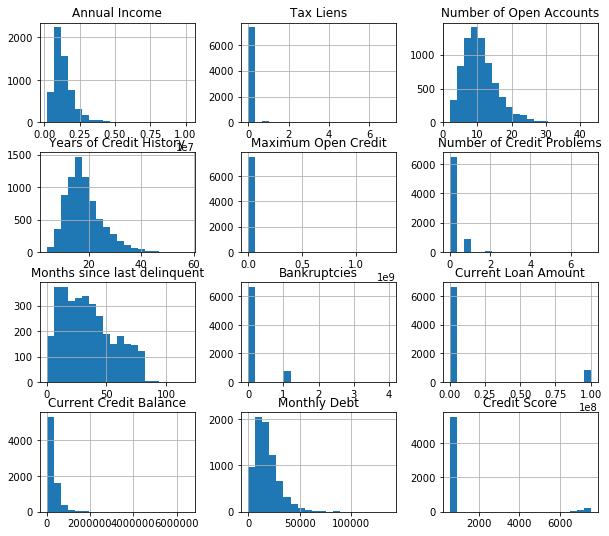

In [15]:
df_num = train_df.select_dtypes(include=['float32','float64'])
#df_num = train_df.select_dtypes(include=['float'])
df_num.hist(figsize=(10,9), bins=20, grid=True);

In [16]:
df_num = train_df.select_dtypes(include=['float32','float64']).columns.tolist()
df_num

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

#### Признак Annual Income

train_df[Annual Income].head() 
0     482087.0
1    1025487.0
2     751412.0
3     805068.0
4     776264.0
Name: Annual Income, dtype: float64

train_df[Annual Income].describe() 
count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

train_df[Annual Income].value_counts() 
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

train_df[Annual Income].sort_values().unique() 
[  164597.   175845.   177251. ...  9338880. 10149344.       nan]



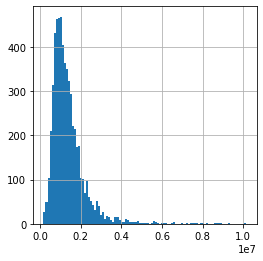

In [17]:
eda('Annual Income', 100)

In [18]:
train_df.loc[(train_df['Annual Income'] > train_df['Annual Income'].quantile(.975))
             &(train_df['Credit Default'] > 0),['Tax Liens']].count()

Tax Liens    23
dtype: int64

#### Признак Tax Liens

train_df[Tax Liens].head() 
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Tax Liens, dtype: float64

train_df[Tax Liens].describe() 
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

train_df[Tax Liens].value_counts() 
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

train_df[Tax Liens].sort_values().unique() 
[0. 1. 2. 3. 4. 5. 6. 7.]



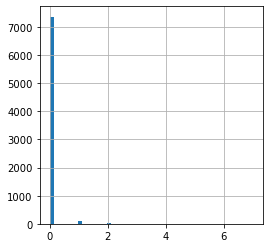

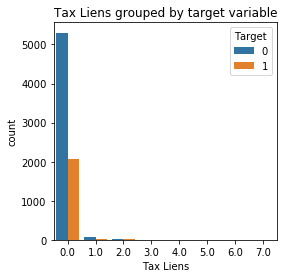

In [19]:
eda('Tax Liens', 50, 1)

In [20]:
train_df.loc[(train_df['Tax Liens'] > 0)&(train_df['Credit Default'] > 0),['Tax Liens']].count()

Tax Liens    48
dtype: int64

#### Признак Number of Open Accounts

train_df[Number of Open Accounts].head() 
0    11.0
1    15.0
2    11.0
3     8.0
4    13.0
Name: Number of Open Accounts, dtype: float64

train_df[Number of Open Accounts].describe() 
count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

train_df[Number of Open Accounts].value_counts() 
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

train_df[Number of Open Accounts].sor

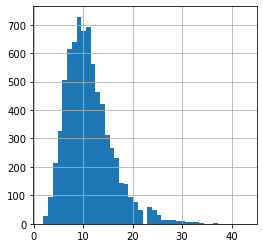

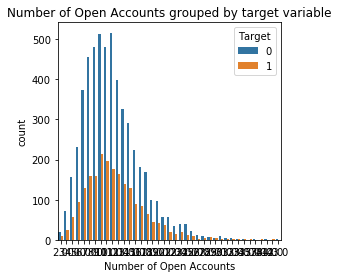

In [21]:
eda('Number of Open Accounts', 43, 1)

In [22]:
train_df.loc[(train_df['Number of Open Accounts'] > 11)&(train_df['Credit Default'] > 0),['Credit Default']].count()

Credit Default    896
dtype: int64

#### Признак Years of Credit History 

train_df[Years of Credit History].head() 
0    26.3
1    15.3
2    35.0
3    22.5
4    13.6
Name: Years of Credit History, dtype: float64

train_df[Years of Credit History].describe() 
count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

train_df[Years of Credit History].value_counts() 
15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

train_df[Years of Credit History].sort_values().unique() 
[ 4.   4.3  4.5  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7
  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1
  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5
  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9
 10.  10.1 10.2 10

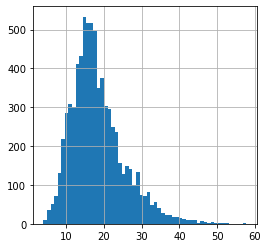

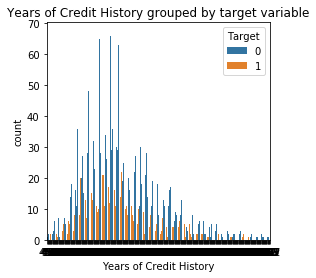

In [23]:
eda('Years of Credit History', 57, 1)

#### Признак Maximum Open Credit

train_df[Maximum Open Credit].head() 
0     685960.0
1    1181730.0
2    1182434.0
3     147400.0
4     385836.0
Name: Maximum Open Credit, dtype: float64

train_df[Maximum Open Credit].describe() 
count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

train_df[Maximum Open Credit].value_counts() 
0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

train_df[Maximum Open Credit].sort_values().unique() 
[0.00000000e+00 4.33400000e+03 6.55600000e+03 ... 2.65512874e+08
 3.80052288e+08 1.30472617e+09]



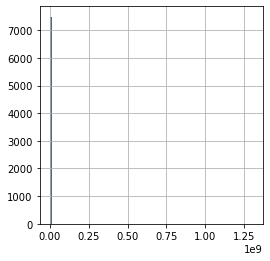

In [24]:
eda('Maximum Open Credit', 100)

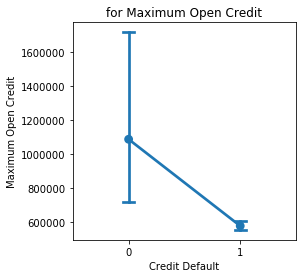

In [25]:
plt.figure(figsize=(4, 4))
sns.pointplot(x='Credit Default', y='Maximum Open Credit', data=train_df, capsize=.1)
plt.title('for Maximum Open Credit')
plt.show()

#### Признак Number of Credit Problems

train_df[Number of Credit Problems].head() 
0    1.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: Number of Credit Problems, dtype: float64

train_df[Number of Credit Problems].describe() 
count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

train_df[Number of Credit Problems].value_counts() 
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

train_df[Number of Credit Problems].sort_values().unique() 
[0. 1. 2. 3. 4. 5. 6. 7.]



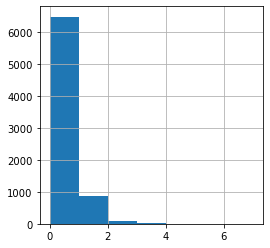

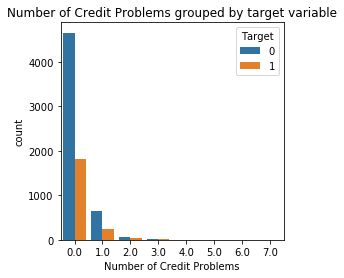

In [26]:
eda('Number of Credit Problems', 7, 1)

In [27]:
train_df.loc[(train_df['Number of Credit Problems'] > 0)&(train_df['Credit Default'] > 0),['Credit Default']].count()

Credit Default    298
dtype: int64

#### Признак Months since last delinquent

train_df[Months since last delinquent].head() 
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Months since last delinquent, dtype: float64

train_df[Months since last delinquent].describe() 
count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

train_df[Months since last delinquent].value_counts() 
14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

train_df[Months since last delinquent].sort_values().unique() 
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.

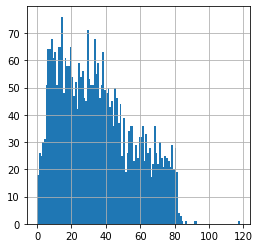

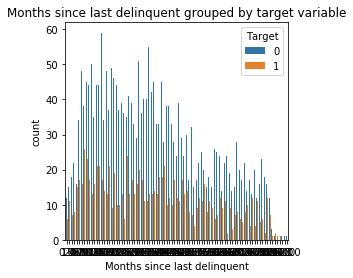

In [28]:
eda('Months since last delinquent', 118, 1)

In [29]:
train_df.loc[(train_df['Months since last delinquent'] > 82)&(train_df['Credit Default'] > 0),['Credit Default']].count()

Credit Default    4
dtype: int64

#### Признак Bankruptcies

train_df[Bankruptcies].head() 
0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: Bankruptcies, dtype: float64

train_df[Bankruptcies].describe() 
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

train_df[Bankruptcies].value_counts() 
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

train_df[Bankruptcies].sort_values().unique() 
[ 0.  1.  2.  3.  4. nan]



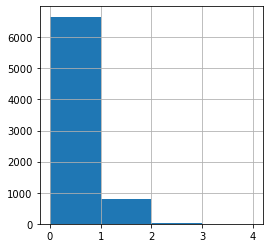

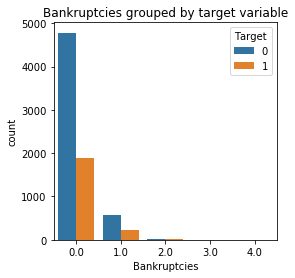

In [30]:
eda('Bankruptcies', 4, 1)

In [31]:
train_df.loc[(train_df['Bankruptcies'] > 0)&(train_df['Credit Default'] > 0),['Credit Default']].count()

Credit Default    231
dtype: int64

#### Признак Current Loan Amount

train_df[Current Loan Amount].head() 
0    99999999.0
1      264968.0
2    99999999.0
3      121396.0
4      125840.0
Name: Current Loan Amount, dtype: float64

train_df[Current Loan Amount].describe() 
count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

train_df[Current Loan Amount].value_counts() 
99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

train_df[Current Loan Amount].sort_values().unique() 
[1.1242000e+04 2.1472000e+04 2.1516000e+04 ... 7.8894200e+05 7.8903000e+05
 9.9999999e+07]



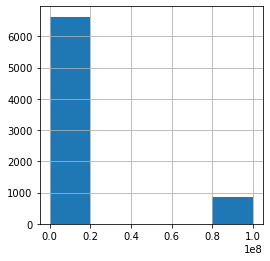

In [32]:
eda('Current Loan Amount')

#### Признак Current Credit Balance

train_df[Current Credit Balance].head() 
0     47386.0
1    394972.0
2    308389.0
3     95855.0
4     93309.0
Name: Current Credit Balance, dtype: float64

train_df[Current Credit Balance].describe() 
count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

train_df[Current Credit Balance].value_counts() 
0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

train_df[Current Credit Balance].sort_values().unique() 
[0.000000e+00 1.900000e+01 5.700000e+01 ... 4.367245e+06 4.720132e+06
 6.506797e+06]



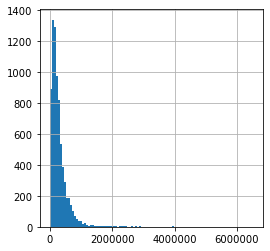

In [33]:
eda('Current Credit Balance', 100)

#### Признак Monthly Debt

train_df[Monthly Debt].head() 
0     7914.0
1    18373.0
2    13651.0
3    11338.0
4     7180.0
Name: Monthly Debt, dtype: float64

train_df[Monthly Debt].describe() 
count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

train_df[Monthly Debt].value_counts() 
0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

train_df[Monthly Debt].sort_values().unique() 
[0.00000e+00 1.70000e+01 2.10000e+01 ... 1.04036e+05 1.10311e+05
 1.36679e+05]



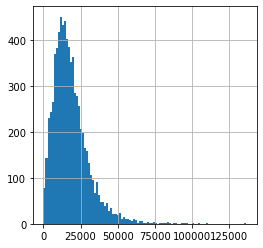

In [34]:
eda('Monthly Debt', 100)

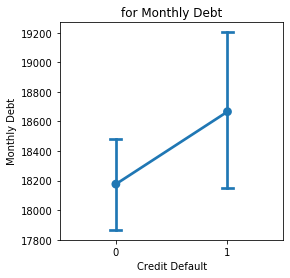

In [35]:
plt.figure(figsize=(4, 4))
sns.pointplot(x='Credit Default', y='Monthly Debt', data=train_df, capsize=.1)
plt.title('for Monthly Debt')
plt.show()

#### Признак Credit Score

train_df[Credit Score].head() 
0    749.0
1    737.0
2    742.0
3    694.0
4    719.0
Name: Credit Score, dtype: float64

train_df[Credit Score].describe() 
count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

train_df[Credit Score].value_counts() 
740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

train_df[Credit Score].sort_values().unique() 
[ 585.  586.  588.  589.  590.  591.  593.  594.  597.  598.  599.  601.
  602.  604.  606.  607.  608.  609.  610.  611.  612.  613.  614.  615.
  616.  617.  618.  619.  620.  621.  622.  624.  625.  626.  627.  628.
  629.  630.  631.  632.  633.  634.  635.  636.  637.  638.  639.  640.
  642.  643.  644.  645.  646.  647.  648.  649.  650.  651.

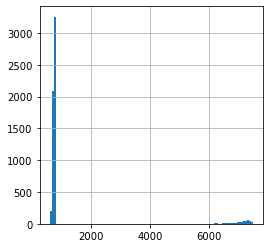

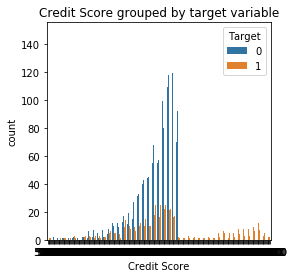

In [36]:
eda('Credit Score', 100, 1)

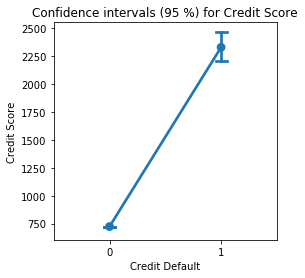

In [37]:
plt.figure(figsize=(4, 4))
sns.pointplot(x='Credit Default', y='Credit Score', data=train_df, capsize=.1)
plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

#### Корреляционная матрица

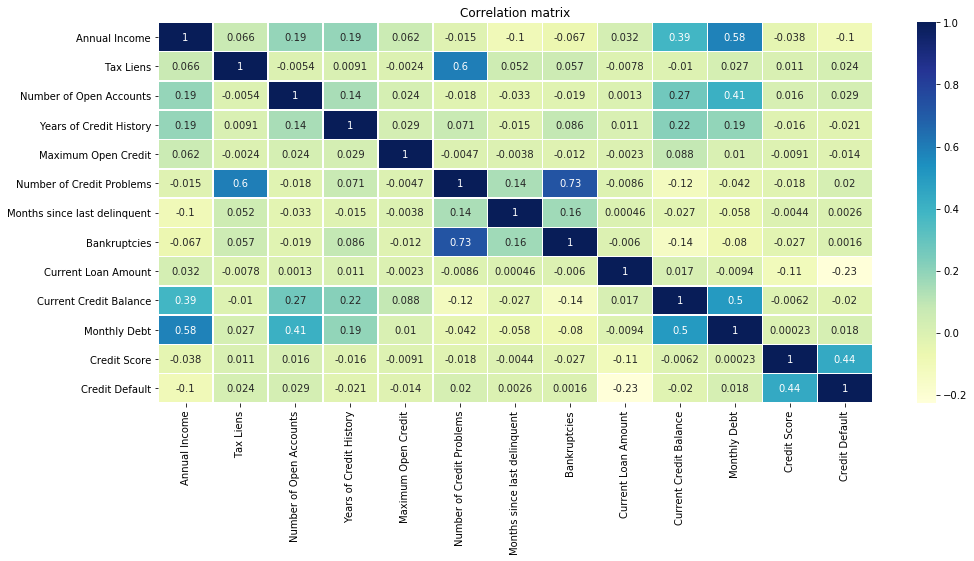

In [38]:
plt.figure(figsize = (16, 7))

sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix')
plt.show()

#### Корреляция с базовыми признаками

In [39]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

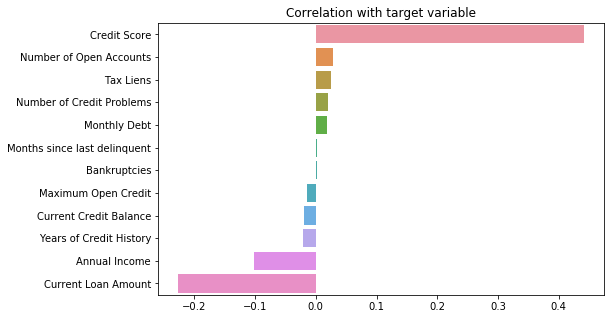

In [40]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

#### Распределение вещественных признаков на трейне и тесте

In [41]:
#df_num
prop_num = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


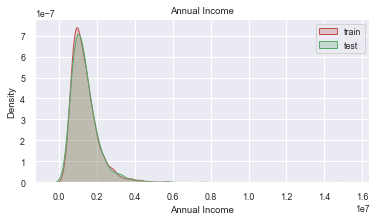

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


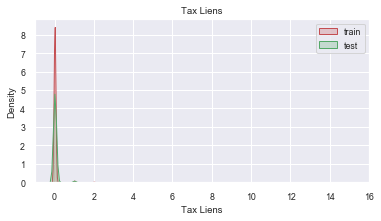

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


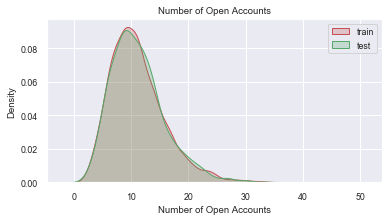

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


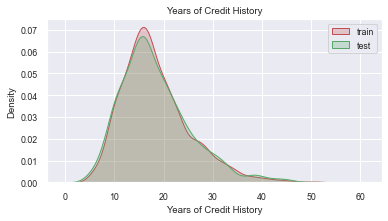

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


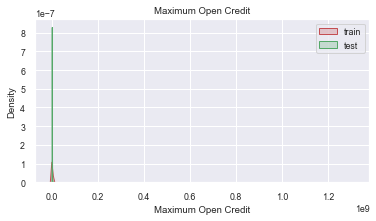

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


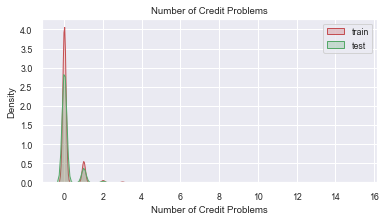

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


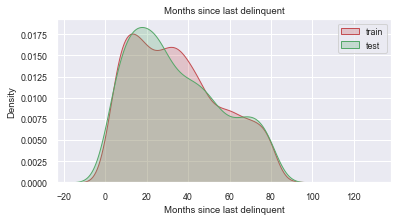

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


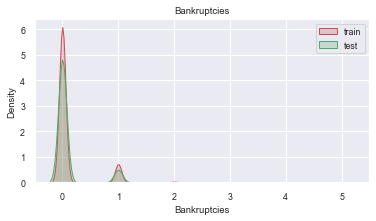

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


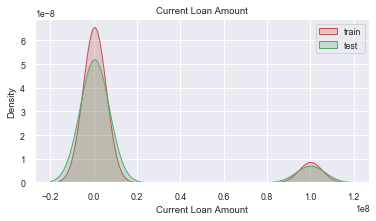

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


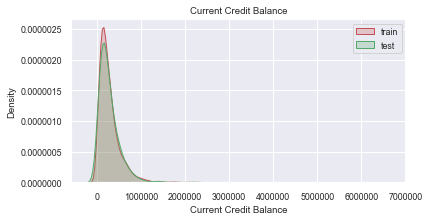

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


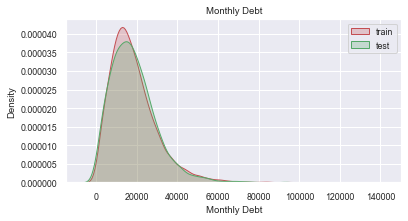

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


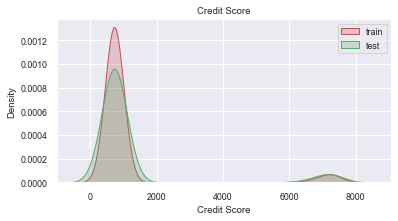

In [42]:
figsize = (6, 3)
for col in prop_num:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

### Номинативные переменные

In [43]:
#prop_cat = train_df.select_dtypes(include='category').columns.tolist() 
prop_cat = train_df.select_dtypes(include='object').columns.tolist() 
prop_cat

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [44]:
for cat_colname in prop_cat:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
**************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
************************

#### Распределение категориальных признаков на трейне и тесте

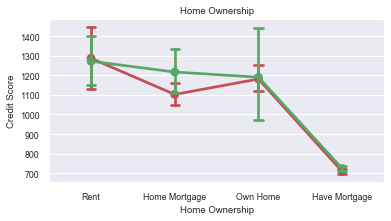

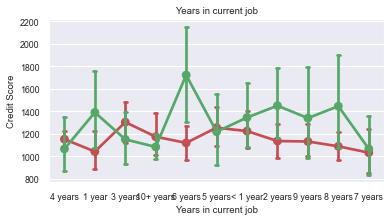

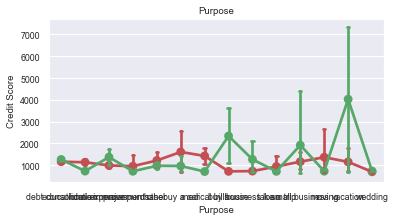

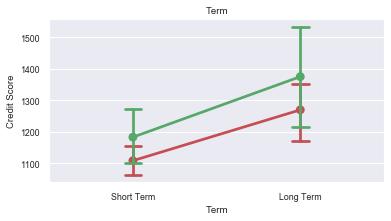

In [45]:
num_feature = 'Credit Score'
for col in prop_cat:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

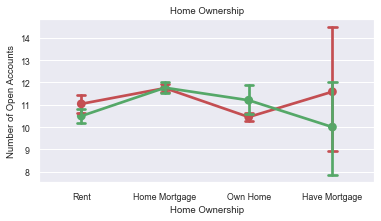

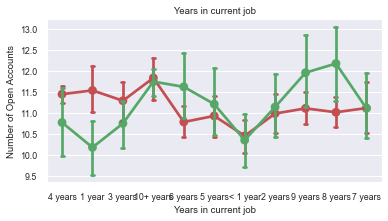

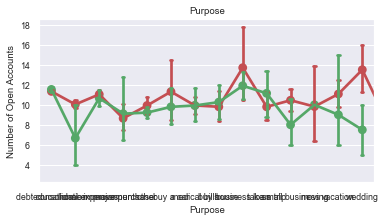

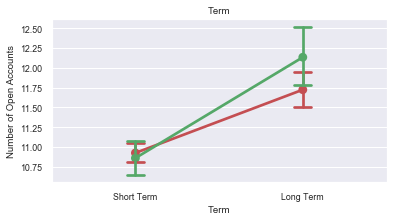

In [46]:
num_feature = 'Number of Open Accounts'
for col in prop_cat:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

### Обработка признаков

In [47]:
class DataPreparation:
    def __init__(self, path_to_file):
        self.current_loan_amount_median = 0
        self.add_dummies_columns = None
        self.df = pd.read_csv(path_to_file)
        
    def get_loan_amount_median(self):
        return self.df[self.df['Current Loan Amount'] <= 9999999.0]['Current Loan Amount'].mean()
    
    def get_default_annual_income(self):
        a_i = self.df[self.df['Annual Income'] != 0]['Annual Income']
        return (2 * a_i.mean() + 3 * a_i.min())/5
    
    def transform(self, current_loan_amount_median, default_annual_income):
        df = self.df.copy()
        add_dummies_columns = None

        YICJ_to_numbers = {'< 1 year':'0',
                            '1 year':'1','2 years':'1','3 years':'1','4 years':'1','5 years':'2', 
                            '6 years':'2','7 years':'2','8 years':'3','9 years':'3',
                            'Years in current job_10+ years':'3'}

        df.loc[df['Purpose'] == 'buy a car', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'buy house', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'home improvements', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        
        df.loc[df['Annual Income'] == 0, 'Current Loan Amount'] = default_annual_income
        
        df.loc[df['Credit Score'] >= 3000, 'Credit Score'] = (df['Credit Score'] / 10)
        df.loc[df['Current Loan Amount'] >= 9999999.0, 'Current Loan Amount'] = current_loan_amount_median
        df['TooBigLoanAmount'] = 1 * (df['Current Loan Amount'] > 9999999.0)
        
        df['Annual Income'].fillna(0.0, inplace=True)
        df['Home Ownership'].fillna('Rent', inplace=True)
        df['Years in current job'].fillna('3 years', inplace=True)
        df['Bankruptcies'].fillna(0.0, inplace=True)
        df['Months since last delinquent'].fillna(0.0, inplace=True)
        df['Credit Score'].fillna(1000.0, inplace=True)
        #df['Credit Score'].fillna(df['Credit Score'].mean//1, inplace=True)
        df['CreditScoreUnknown'] = 1 * (df['Credit Score'] == 0.0)

        df.loc[df['Bankruptcies'] >= 3, 'Bankruptcies'] = 3
        df['Years in current job'] = df['Years in current job'].map(YICJ_to_numbers)

        columns_old = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Home Ownership','Purpose'])
        columns_current = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Term','Years in current job'])
        columns_new = set(df.columns.tolist())
    
        for col in list(columns_new - columns_current):
            df[col] = df[col] * df['Current Loan Amount']
            #df['AI '+col] = df[col] * df['Annual Income']
            df['CS '+col] = df[col] * df['Credit Score']
    
        columns_new = set(df.columns.tolist())
        self.add_dummies_columns = list(columns_new - columns_old)
        
        return df

### Балансировка

In [48]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Обучающая модель

In [49]:
class TeachModel:
    def __init__(self, X, y, target_name):
        model = None
        classification_report = None
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, shuffle=True, test_size=0.21, random_state=79)
        df_for_balancing = pd.concat([X_train, y_train], axis=1)
        df_balanced = balance_df_by_target(df_for_balancing, target_name)
        self.X_train = df_balanced.drop(columns=target_name)
        self.y_train = df_balanced[target_name]
        
    def log_regression(self, X):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def knn(self, X):
        self.model = KNeighborsClassifier()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def xgb(self, X, r_state):
        self.model = xgb.XGBClassifier(random_state=r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def lgbm(self, X, r_state):
        self.model = lgbm.LGBMClassifier(random_state=r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def cat_boost(self, X, r_state,n_est,m_depth, cw):
        self.model = catb.CatBoostClassifier(random_state=r_state, silent = True, n_estimators = n_est, max_depth = m_depth, class_weights = cw)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)

### Отбор признаков 

In [50]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     #'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     #'Months since last delinquent',
                     'Current Credit Balance',
                     'Monthly Debt',
                     'Credit Score',
                     'TooBigLoanAmount',
                     'CreditScoreUnknown'
                    ]
TARGET_NAME = 'Credit Default'

### Подготовка данных

In [51]:
train_data_preparation = DataPreparation(TRAIN_DATASET_PATH)
current_loan_amount_median = train_data_preparation.get_loan_amount_median()
default_annual_income = train_data_preparation.get_default_annual_income()
train_df = train_data_preparation.transform(current_loan_amount_median, default_annual_income)
#train_df.columns
train_df = train_df[train_data_preparation.add_dummies_columns + NUM_FEATURE_NAMES + [TARGET_NAME]]

In [52]:
test_data_preparation = DataPreparation(TEST_DATASET_PATH)
test_df = test_data_preparation.transform(current_loan_amount_median, default_annual_income)
test_df = test_df[test_data_preparation.add_dummies_columns + NUM_FEATURE_NAMES]

### Обучение модели

In [53]:
teach_model = TeachModel(train_df[train_data_preparation.add_dummies_columns + NUM_FEATURE_NAMES], train_df[TARGET_NAME], TARGET_NAME)
predictions = teach_model.cat_boost(test_df, r_state = 167, n_est = 33, m_depth=3, cw = [1,1.07])

### Подсчет метрик

In [54]:
rez_trn = 'TRAIN\n' + teach_model.classification_report['train_report']
print(rez_trn)
rez_tst = 'TEST\n' + teach_model.classification_report['test_report']
print(rez_tst)
print('CONFUSION MATRIX\n')
print(teach_model.classification_report['crosstab'])

TRAIN
             precision    recall  f1-score   support

          0       0.72      0.72      0.72      4271
          1       0.64      0.64      0.64      3308

avg / total       0.69      0.69      0.69      7579

TEST
             precision    recall  f1-score   support

          0       0.78      0.69      0.74      1116
          1       0.42      0.54      0.47       459

avg / total       0.68      0.65      0.66      1575

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               773  343
1               212  247


### Важность признаков

In [55]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (15, len(feature_importances) * 0.3))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

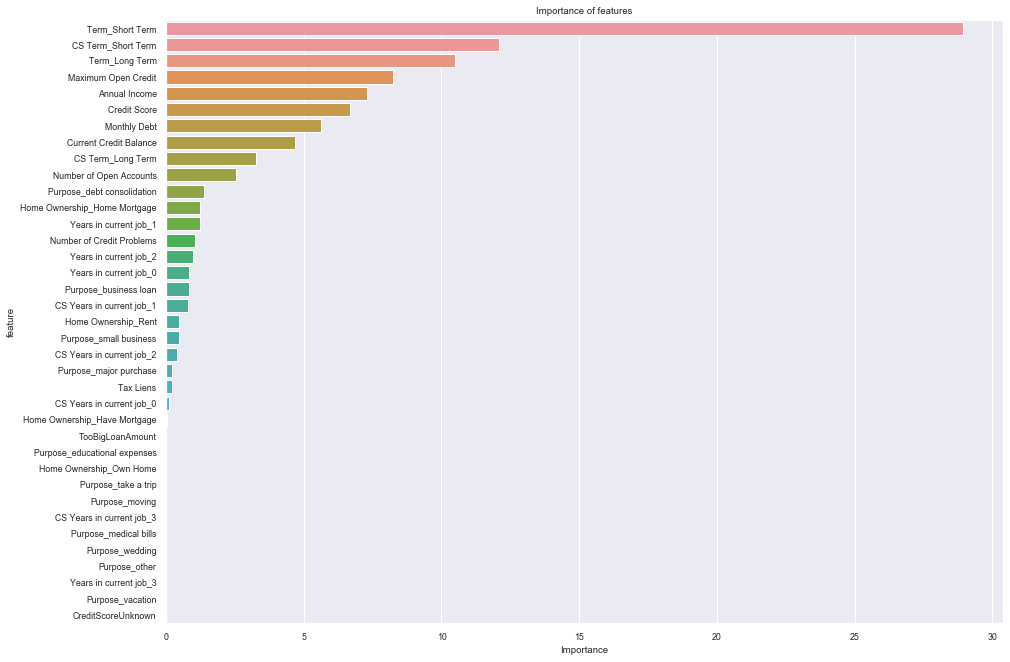

In [56]:
important_features_top = show_feature_importances(teach_model.X_train.columns, teach_model.model.feature_importances_, get_top=15)

### Сохранение результата

In [57]:
#submit = pd.read_csv('/kaggle/input/gb-credit-default/sample_submission.csv')
submit = pd.read_csv('./input/sample_submission.csv')
submit['Credit Default'] = predictions
submit.to_csv('rf_submit.csv', index=False)
submit 

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,0


In [58]:
print(datetime.now() - t1)

0:00:40.793042
